In [2]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.general import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *



In [41]:
# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = random
# phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
# phaseoffsetfunction = Phase_MinJumps
# harmonicremoval = True
# #Cost Functions available: Pen_DiscreteLinear, Pen_Linear, Pen_Log
# gwscostfunction = Pen_DiscreteLinear
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity
# errormetric = Err_MaxMinDiff



In [24]:
## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    print("cupy not installed. Using numpy.")

cupy not installed. Using numpy.


In [46]:
# Initial phase guess 

# def makeinitialkvectors(tweezerarray):
#     return kvectors


# Tweezer generation

def createtweezers_grid(blankinput, spacing, xnum, ynum):
    """Creates delta function at tweezer locations. blankinput is a blank input array to 
    initialize tweezer in, spacing is the pixel spacing between tweezers, and xnum and ynum are the 
    number of tweezers in the respective directions. Auto-centered and created."""
    simplegrating = cp.zeros(cp.shape(blankinput))
    ysize = cp.shape(blankinput)[0]
    xsize = cp.shape(blankinput)[1]

    for i in range(xsize // 2 + xsize // 10, xsize // 2 + xsize // 10+ spacing*xnum ):
        for j in range(ysize//2 - spacing * ynum // 2 ,ysize // 2 + spacing*ynum // 2):
            pixcoord = 0
            distj1 = j  % spacing
            disti1 = i  % spacing
            distj2 = (spacing - j) % spacing
            disti2 = (spacing - i) % spacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            xrad = 1
            yrad = 1
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating


def derivephase(costfunction, targetintensity, initialphase, iterations, beamtype="Gaussian", magnification = 1):
    """All inputs are assumed to be of the same dimensionality, 1300 by 1300. Note that magnification adds on to the target, so
    if target is already 3900 by 3900 magnification of 2 will make the simulation space much(!) larger. Beamtypes available are Gaussian or Constant."""
    # Remember, the calculation region is only numpixels by numpixels
    
    # Just in case we're using a highly precise target (so not delta function)
    targetmagnification = cp.shape(targetintensity)[0] // numpixels
    magnification = targetmagnification * magnification
    
    slmphase = set_circlemask(expand(initialphase, magnification), numpixels *magnification)
    inputbeam = set_circlemask(createbeam(beamtype, numpixels * magnification), numpixels * magnification)
    slmplane = join_phase_ampl(slmphase, inputbeam)
    
    fourierplane=cp.zeros((numpixels,numpixels),dtype=complex)
    weights=cp.ones((numpixels * magnification, numpixels*magnification))
    weights_previous = targetintensity.copy()
    
    stdinttracker = [] # For use in error calculations
    
    for _ in range(iterations):
        startingpower = cp.sum(cp.abs(slmplane)**2)
        fourierplane = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(slmplane), norm="ortho"))
        fourierintensity = cp.square(cp.abs(fourierplane))
        stdint = cp.divide(fourierintensity, np.max(fourierintensity))
        stdinttracker.append(stdint)
        weights = costfunction(weights, weights_previous, targetintensity, stdint)
        weights_previous = weights.copy()
        ## This might be a bit confusing, but weights is now the amplitude and we re-combine it with the phase to get the next iteration
        fourierangle = cp.angle(fourierplane)
        fourierplane = join_phase_ampl(fourierangle, weights)
        slmplane = cp.fft.ifftshift(cp.fft.ifft2(cp.fft.ifftshift(fourierplane), norm="ortho"))     
        endingpower = cp.sum(cp.abs(slmplane)**2)
        slmplane = cp.multiply(cp.divide(slmplane, endingpower), startingpower)
        slmplane_numpixels = slmplane.copy()
        slmplane_numpixels = cp.mean(slmplane_numpixels.reshape(numpixels, magnification, numpixels, magnification), axis=(-3,-1))
        
        slmphase = undiscretize_phase(discretize_phase(set_circlemask(cp.angle(slmplane_numpixels), numpixels)))
        readout_slmphase = slmphase.copy()
        slmplane = join_phase_ampl(expand(slmphase, magnification), inputbeam)
        
    
    return readout_slmphase, stdinttracker, stdint

    

## Algorithm subfunctions

def discretize_phase(phase):
    phase=cp.round((phase+cp.pi)*255/(2*cp.pi))
    return(phase)

def undiscretize_phase(phase):
    phase=phase/255*(2*cp.pi)-cp.pi
    return(phase)

def set_circlemask(inputmatrix, radius):
    image = inputmatrix
    image[cp.sqrt((cp.arange(image.shape[0])[:,None] - image.shape[0]//2)**2 + (cp.arange(image.shape[1]) - image.shape[1]//2)**2) > radius] = 0
  
    return image

def createbeam(beamtype, size, sigma=1, mu = 1):
    blank = cp.zeros((size,size), dtype=complex)
    if beamtype == "Gaussian":
        x, y = cp.meshgrid(cp.linspace(-1,1,size), cp.linspace(-1,1,size))
        d = cp.sqrt(x*x+y*y)
        g = cp.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
        blank = g
    elif beamtype == "Constant":
        blank[:,:] = 1
    ### More support may be added in the future.
    return blank
    

### Cost functions
def weights(w,w_prev,target_im,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
    # targetmatch_indices = np.argwhere(target_im==1)
    # for i in targetmatch_indices:
    #     for x in range(-2,3):
    #         for y in range(-2,3):
    #             w[i[0]+x,i[1]+y] = np.sqrt((target_im[i[0]+x,i[1]+y] / std_int[i[0]+x,i[1]+y])) *w_prev[i[0]+x,i[1]+y]
    #             # w[target_im!=1] = np.sqrt(1 / (1-screwone(std_int[target_im!=1]))) * w_prev[target_im!=1]
    w[target_im==1] = cp.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    return (w)

def weights_gaussian(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
    # targetmatch_indices = np.argwhere(target_im==1)
    # for i in targetmatch_indices:
    #     for x in range(-2,3):
    #         for y in range(-2,3):
    #             w[i[0]+x,i[1]+y] = np.sqrt((target_im[i[0]+x,i[1]+y] / std_int[i[0]+x,i[1]+y])) *w_prev[i[0]+x,i[1]+y]
    #             # w[target_im!=1] = np.sqrt(1 / (1-screwone(std_int[target_im!=1]))) * w_prev[target_im!=1]
    w[target_im!=0] = cp.sqrt((target_im[target_im!=0] / std_int[target_im!=0])) * w_prev[target_im!=0]
    return (w)

def weightintensity_lukin(target, target_prev, std_int, target_im):
    target[target_im==1] = cp.sqrt((cp.mean(std_int[target_im==1]) / (std_int[target_im==1]+0.001))) * target_prev[target_im==1]
    return target




# Quality of life

def zoomin(array):
    """zooms into the region of interest, threshold is just the average pixel value"""
    threshold = cp.mean(array) * 1.5
    coordinates = cp.argwhere(array > threshold)
    if coordinates.size > 0:
        min_y, min_x = cp.min(coordinates, axis=0)
        max_y, max_x = cp.max(coordinates, axis=0)
    else:
        min_y = min_x = max_y = max_x = None

    zoomedarray = array[min_y-20:max_y+20, min_x-20:max_x+20]
    
    return zoomedarray

def expand(array, multiplier=3):
    """ expands array based on multiplier for use in GWS algorithm or fourier imaging"""
    expanded_array = cp.kron(array, cp.ones((multiplier, multiplier)))
    return expanded_array

def norm(matrix):
    min=cp.min(matrix);max=cp.max(matrix)
    return((matrix-min)/(max-min))

def join_phase_ampl(phase,ampl):
    tmp=cp.zeros((ampl.shape[0],ampl.shape[1]),dtype=complex)
    tmp = cp.multiply(ampl,cp.exp(phase*1j))
    return tmp

# Visualization

# def tweezer


def tweezerintensities(tweezerarray, scale,):
    
    
    return intensityplot
 


In [47]:
inputarray = np.zeros((numpixels,numpixels))
tweezertarget = createtweezers_grid(inputarray, 3, 20,20 )

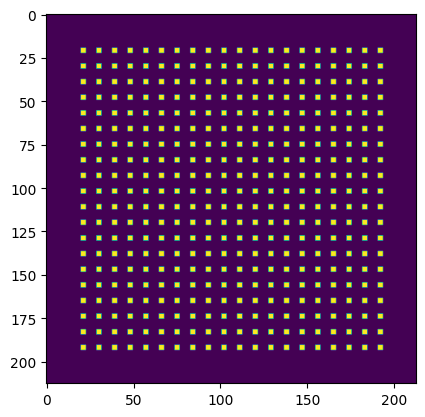

In [48]:
plt.imshow(zoomin(expand(tweezertarget,3)))

In [51]:
testphase, teststdlist, teststd = derivephase(weights, tweezertarget, np.random.rand(numpixels, numpixels),20)

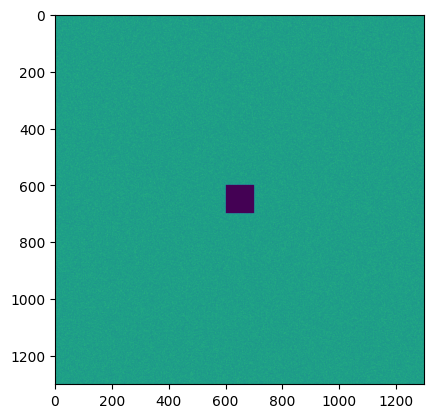

In [56]:
plt.imshow(teststd)